# Introduction

Trying to get a good UMAP. this is to compare cellranger arc to what should be the closest star run.

In [1]:
import anndata
import scipy
import pandas
import scanpy
import numpy
from pathlib import Path
from matplotlib import pyplot
import sys
import pysam
from collections import Counter

In [2]:
pwd

'/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/adrenal/ENCSR724KET_16f_nuc'

In [3]:
project_root = Path("../..").absolute()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from common import compute_spearman_anndata

In [4]:
def scanpy_load_solo278a_mtx(analysis_dir, quantification="Gene", mode="filtered"):
    assert mode in ["filtered", "raw"], "STAR Solo only produces raw or filtered files"
    assert quantification in ["Gene", "GeneFull", "GeneFull_Ex50pAS", "SJ"]

    analysis_dir = Path(analysis_dir)
    feature_name = "features.tsv"
    
    solo_dir = analysis_dir / "Solo.out" / quantification / mode
    solo = scanpy.read_mtx(solo_dir / "matrix.mtx").T
    solo_vars = pandas.read_csv(
        solo_dir / feature_name, header=None, sep="\t"
    ).values.T
    solo_obs = pandas.read_csv(
        solo_dir / "barcodes.tsv", header=None, sep="\t"
    ).values.T
    solo.obs_names = solo_obs[0]
    solo.var_names = solo_vars[0]

    solo.obs["counts"] = solo.X.sum(axis=1)
    solo.obs["ngenes"] = numpy.array((solo.X > 0).sum(axis=1))

    return solo



In [5]:
tenx_root = Path('ENCSR724KET_cr-arc')
tenx_raw_path = tenx_root / 'outs' / 'raw_feature_bc_matrix'
tenx_filtered_path = tenx_root / 'outs' / 'filtered_feature_bc_matrix'

In [6]:
tenx_filtered = scanpy.read_10x_mtx(tenx_filtered_path, var_names='gene_ids')
tenx_filtered.obs_names = [x[:-2] for x in tenx_filtered.obs_names]

In [7]:
solo278a_root = Path("tenxsolo_multi_dev_EoI_2.7.9a_2021-09-10")
solo278a_genefull = scanpy_load_solo278a_mtx(solo278a_root, "GeneFull_Ex50pAS", "filtered")

In [8]:
v32m_genome_dir = Path("~/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/").expanduser()
v32m_store = pandas.HDFStore(v32m_genome_dir / "GRCh38-arc2.0-2.7.8a" / "GRCh38-arc2.0-2.7.8a.h5")
v32m_gtf = v32m_store.select('/gtf', where='type == gene', columns=['gene_id', 'gene_name', 'gene_type'])
v32m_store.close()

v32m_gtf.columns = ['gene_base', 'gene_name', 'gene_type']
#v32m_gtf['gene_id'] = v32m_gtf['gene_base'].apply(lambda x: v29_gene_base_to_id.get(x, x))

v32m_gene_id_to_name = {}
v32m_gene_id_to_type = {}
for i, row in v32m_gtf.iterrows():
    v32m_gene_id_to_name[row.gene_base] = row.gene_name
    v32m_gene_id_to_type[row.gene_base] = row.gene_type

In [9]:
solo278a_genefull.var['gene_name'] = [v32m_gene_id_to_name.get(x, x) for x in solo278a_genefull.var_names]
solo278a_genefull.var['gene_type'] = [v32m_gene_id_to_type.get(x, x) for x in solo278a_genefull.var_names]


In [10]:
print("tenx filtered", tenx_filtered.shape, tenx_filtered.X.sum())
print("solo genefull", solo278a_genefull.shape, solo278a_genefull.X.sum())

tenx filtered (13650, 36601) 80119070.0
solo genefull (15859, 36601) 84515990.0


In [11]:
common_barcodes = [ x for x in tenx_filtered.obs_names if x in set(tenx_filtered.obs_names).intersection(solo278a_genefull.obs_names)]

In [12]:
solo278a_filtered_genefull = solo278a_genefull[common_barcodes,:]
solo278a_filtered_genefull.shape, solo278a_filtered_genefull.X.sum()

((13541, 36601), 80839656.0)

In [13]:
solo278a_filtered_genefull.X.sum(axis=1).shape

(13541, 1)

In [14]:
tenx_common = tenx_filtered[common_barcodes,:]

In [15]:
filtered_cors = compute_spearman_anndata(tenx_common, solo278a_filtered_genefull)

/usr/lib/python3/dist-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [16]:
tenx_common

View of AnnData object with n_obs × n_vars = 13541 × 36601
    var: 'gene_symbols', 'feature_types'

In [17]:
tenx_common_sum = pandas.Series(numpy.asarray(tenx_common.X.sum(axis=1)).T[0])


In [18]:
tenx_idxmax = tenx_common_sum.idxmax()
tenx_max_cell = tenx_common.obs_names[tenx_idxmax]
tenx_max_cell

'GCATCCTTCTAAGTGC'

In [19]:
tfg = tenx_filtered[tenx_max_cell].to_df().T
tfg.describe()

,GCATCCTTCTAAGTGC
count,36601.000000
mean,3.866807
std,72.393562
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,13634.000000


In [20]:
sfg = solo278a_filtered_genefull[tenx_max_cell].to_df().T
sfg.describe()

,GCATCCTTCTAAGTGC
count,36601.000000
mean,3.906669
std,72.250038
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,13600.000000


In [21]:
assert numpy.all(tfg.index == sfg.index), "feature lists are not in same order "

In [22]:
rad = (numpy.abs(sfg - tfg) / numpy.maximum(sfg, tfg))

<AxesSubplot:ylabel='Frequency'>

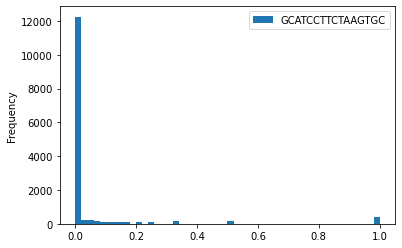

In [23]:
rad.plot.hist(bins=50)

In [24]:
combined_gene = pandas.merge(sfg, tfg, left_index=True, right_index=True, suffixes=("_star", "_cr-arc"))

# Compare cell GCATCCTTCTAAGTGC between cellranger and STAR solo gene

<ipython-input-25-3fd4f3200269>:4: RuntimeWarning: divide by zero encountered in log2
  p = numpy.log2(combined_gene).plot.scatter(x="{}_star".format(tenx_max_cell), y="{}_cr-arc".format(tenx_max_cell), ax=ax)


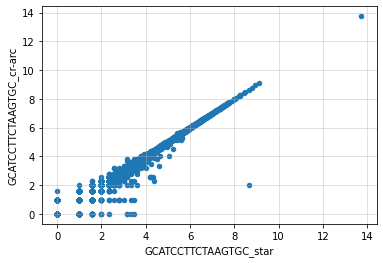

In [25]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)

p = numpy.log2(combined_gene).plot.scatter(x="{}_star".format(tenx_max_cell), y="{}_cr-arc".format(tenx_max_cell), ax=ax)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim(0,1e5)
#ax.set_ylim(0,1e5)
ax.grid(alpha=.5)

Wait a second... that looks like cell ranger has higher expression... what did they change? Are they counting introns? Multireads?

In [26]:
gene_cors = compute_spearman_anndata(tenx_common, solo278a_filtered_genefull)

/usr/lib/python3/dist-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Compare per cell gene spearman correlation

There is a warning message from the spearman function complaining that the input matrix has an issue, so this histogram may be incorrect.

<AxesSubplot:ylabel='Frequency'>

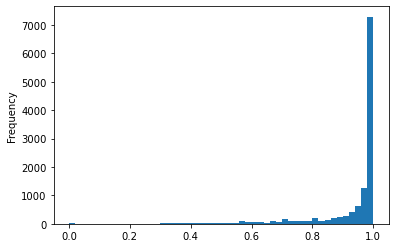

In [27]:
gene_cors.plot.hist(bins=50)

# Prepare GeneFull comparisons

In [28]:
common_genefull_barcodes = [ x for x in tenx_filtered.obs_names if x in set(tenx_filtered.obs_names).intersection(solo278a_genefull.obs_names)]
solo278a_filtered_genefull = solo278a_genefull[common_genefull_barcodes,:]
sfgf = solo278a_filtered_genefull[tenx_max_cell].to_df().T
sfgf.describe()

,GCATCCTTCTAAGTGC
count,36601.000000
mean,3.906669
std,72.250038
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,13600.000000


In [29]:
combined_genefull = pandas.merge(sfgf, tfg, left_index=True, right_index=True, suffixes=("_star", "_cr-arc"))

In [30]:
def plot_cell(star, cr, cell):
    star_cell = star[cell].to_df().T
    cr_cell = cr[cell].to_df().T
    combined = pandas.merge(star_cell, cr_cell, left_index=True, right_index=True, suffixes=("_star", "_cr-arc"))
    f = pyplot.figure()
    ax = f.add_subplot(1,1,1)

    p = numpy.log2(combined).plot.scatter(x="{}_star".format(cell), y="{}_cr-arc".format(cell), ax=ax)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xlim(0,1e5)
    #ax.set_ylim(0,1e5)
    ax.grid(alpha=.5)

# Compare cell GCATCCTTCTAAGTGC between cellranger and STAR solo genefull

<ipython-input-30-35c547c9dd5b>:8: RuntimeWarning: divide by zero encountered in log2
  p = numpy.log2(combined).plot.scatter(x="{}_star".format(cell), y="{}_cr-arc".format(cell), ax=ax)


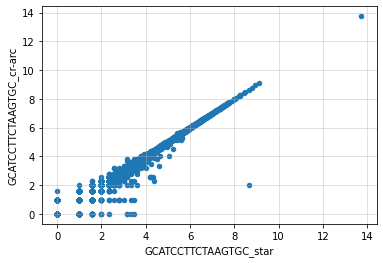

In [31]:
plot_cell(solo278a_filtered_genefull, tenx_filtered, tenx_max_cell)

In [32]:
tenx_common_genefull = tenx_filtered[common_genefull_barcodes,:]
genefull_cors = compute_spearman_anndata(tenx_common_genefull, solo278a_filtered_genefull)

/usr/lib/python3/dist-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Plot GeneFull correlations

<AxesSubplot:ylabel='Frequency'>

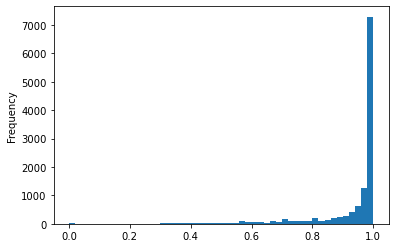

In [33]:
genefull_cors.plot.hist(bins=50)

Well that's an improvement. Looks like they're counting introns.

In [34]:
genefull_cors[(genefull_cors > 0.8) & (genefull_cors < 0.81)]

AAGCGAGGTATTCGCT    0.801636
AATCCTAAGGGACGCA    0.803919
ACTAAAGCAAAGCGGC    0.801950
AGATGCTTCCAAGTTA    0.809214
AGCGGATAGTTGTCAA    0.804592
AGTATAGCATTAGGCC    0.801093
ATGAGCCGTAGTTACG    0.807138
ATTGGCTAGCGCAATT    0.801553
CAAGACAAGCACTAAC    0.800961
CACCGGTAGTATCGCG    0.807063
CAGCTATAGACTAAGG    0.803919
CATGCGGGTGCTTTAC    0.808889
CCCAGTTTCAGGGCCT    0.801675
CCCATAACACATAACT    0.803323
CCTGTAACACTTCATC    0.805130
CCTTCAATCCTTGCGT    0.801675
CGACTAAGTCGTTATC    0.801675
CGAGGTGAGGCACAGG    0.801636
CGGACAACAAACTGTT    0.801675
CGTGCTTTCGCAATCG    0.806633
CTAATCTTCGAGCAAA    0.809562
CTCACTCAGGACTAAG    0.800457
CTCTTGATCAGGCTAT    0.804786
GAAGTGATCTAACCAA    0.800628
GAGCGGTCACAGGGAC    0.808245
GAGGGAGCAACTGGCT    0.808919
GATCGCTCAACTGGCT    0.807033
GATTACTCAAACTAAG    0.804221
GATTAGTGTGTTGCTT    0.801675
GATTCGCCAGGCAAGC    0.807003
GCAAGTCGTTAATGCG    0.809610
GCCAACATCCTCCATA    0.803024
GCCAATTAGGACCAGG    0.807003
GCCTCAAAGTCCTGAG    0.800381
GCTAGTGTCGTTTC

In [35]:
cell_id = genefull_cors[(genefull_cors > 0.8) & (genefull_cors < 0.81)].index[0]

<ipython-input-30-35c547c9dd5b>:8: RuntimeWarning: divide by zero encountered in log2
  p = numpy.log2(combined).plot.scatter(x="{}_star".format(cell), y="{}_cr-arc".format(cell), ax=ax)


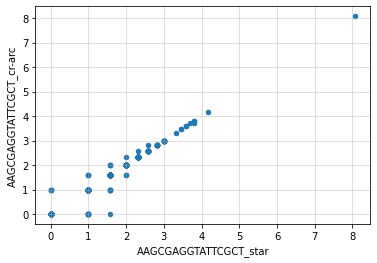

In [36]:
plot_cell(solo278a_filtered_genefull, tenx_filtered, cell_id)

In [37]:
ok_solo_cell = solo278a_filtered_genefull[cell_id].to_df().T
ok_cr_cell = tenx_common_genefull[cell_id].to_df().T

ok_cells = pandas.merge(ok_solo_cell, ok_cr_cell, left_index=True, right_index=True, suffixes=("_solo", "_cr"))

ok_cells.shape

(36601, 2)

In [38]:
different =  (ok_cells['{}_solo'.format(cell_id)] != ok_cells['{}_cr'.format(cell_id)])


In [39]:
ok_cells[different].sort_values(by="{}_solo".format(cell_id))

,AAGCGAGGTATTCGCT_solo,AAGCGAGGTATTCGCT_cr
ENSG00000138614,0.0,1.0
ENSG00000104695,0.0,1.0
ENSG00000287306,0.0,1.0
ENSG00000287075,0.0,1.0
ENSG00000255760,0.0,1.0
...,...,...
ENSG00000204291,4.0,3.0
ENSG00000140836,5.0,6.0
ENSG00000145425,6.0,7.0
ENSG00000230876,9.0,0.0


In [40]:
ok_cells[different].sort_values(by="{}_cr".format(cell_id))

,AAGCGAGGTATTCGCT_solo,AAGCGAGGTATTCGCT_cr
ENSG00000133138,1.0,0.0
ENSG00000149177,1.0,0.0
ENSG00000157423,1.0,0.0
ENSG00000111846,1.0,0.0
ENSG00000197977,1.0,0.0
...,...,...
ENSG00000230590,3.0,4.0
ENSG00000151276,4.0,5.0
ENSG00000140836,5.0,6.0
ENSG00000145425,6.0,7.0


# Scanpy stuff

In [41]:
algorithm_filtered = {
    "cellranger-arc": tenx_filtered,
    "solo full 50%": solo278a_genefull,
}

combined = anndata.concat(
    [algorithm_filtered[x] for x in algorithm_filtered],
    merge='same',
)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [42]:
combined.var['gene_symbol'] = [v32m_gene_id_to_name.get(x, x) for x in combined.var_names]
combined.var['gene_type'] = [v32m_gene_id_to_type.get(x, x) for x in combined.var_names]
combined

AnnData object with n_obs × n_vars = 29509 × 36601
    var: 'gene_symbol', 'gene_type'

In [43]:
method = []
for algorithm in algorithm_filtered:
    method.extend([algorithm] * len(algorithm_filtered[algorithm].obs_names))
print(len(method), len(algorithm_filtered[algorithm].obs_names))
print(combined.shape)
combined.obs['method'] = method
combined

29509 15859
(29509, 36601)


AnnData object with n_obs × n_vars = 29509 × 36601
    obs: 'method'
    var: 'gene_symbol', 'gene_type'

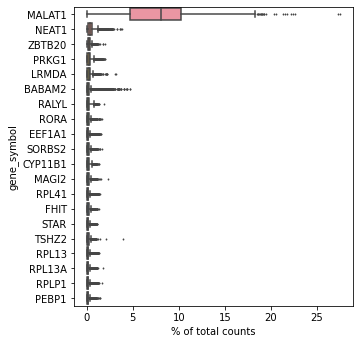

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'method' as categorical
... storing 'gene_symbol' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"

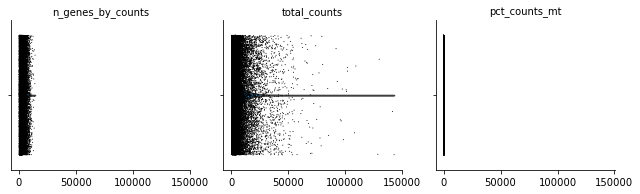

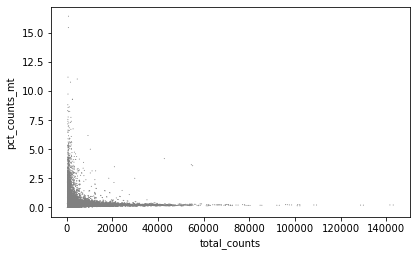

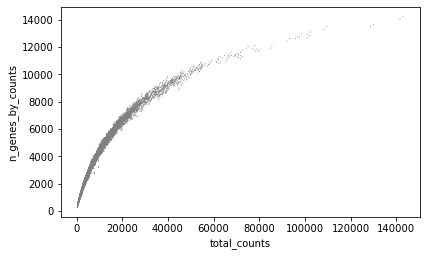

In [44]:
scanpy.pl.highest_expr_genes(combined, n_top=20, gene_symbols='gene_symbol')
scanpy.pp.filter_cells(combined, min_genes=200)
scanpy.pp.filter_genes(combined, min_cells=3)
combined.var['mt'] = combined.var['gene_symbol'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(combined, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
scanpy.pl.violin(
    combined,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True)
scanpy.pl.scatter(combined, x='total_counts', y='pct_counts_mt')
scanpy.pl.scatter(combined, x='total_counts', y='n_genes_by_counts')

/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


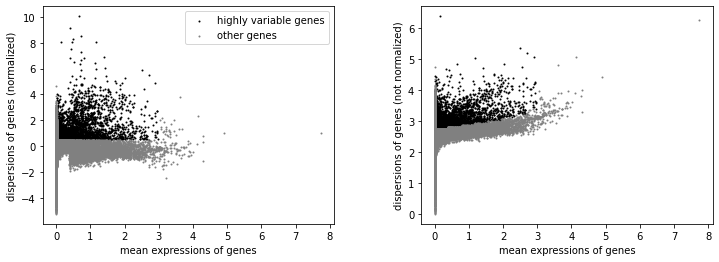

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


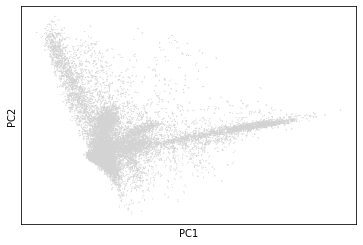

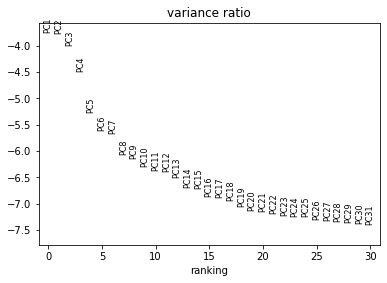

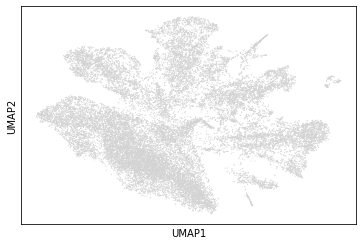

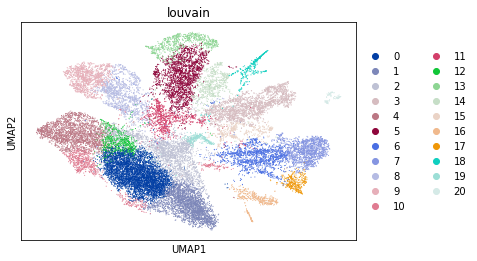

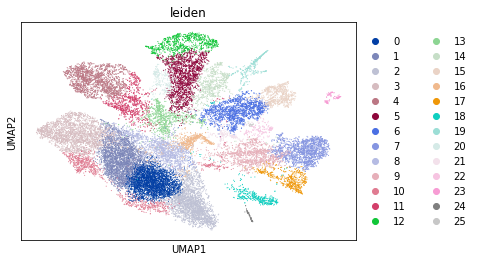

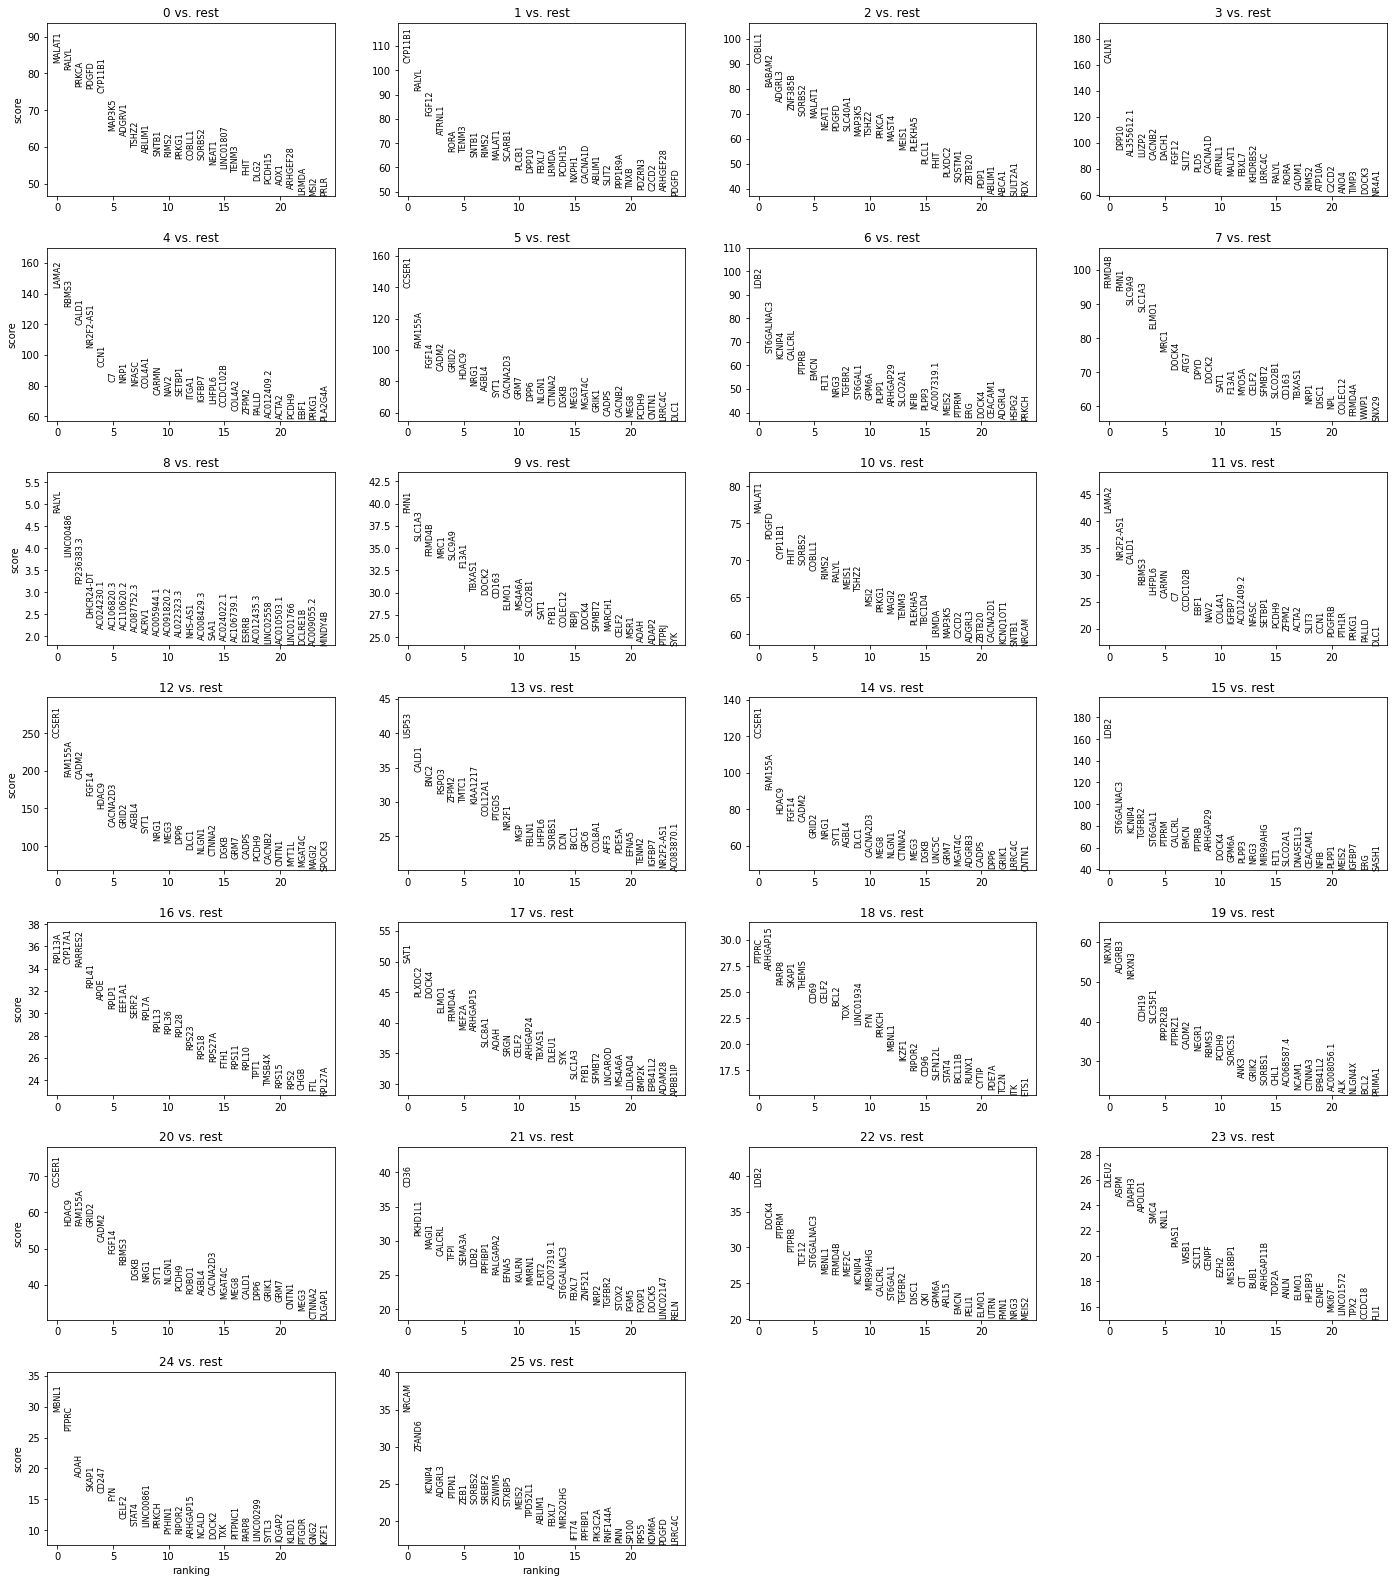

top gene names
top gene names


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,MALAT1,CYP11B1,COBLL1,CALN1,LAMA2,CCSER1,LDB2,FRMD4B,RALYL,FMN1,...,RPL13A,SAT1,PTPRC,NRXN1,CCSER1,CD36,LDB2,DLEU2,MBNL1,NRCAM
1,RALYL,RALYL,BABAM2,DPP10,RBMS3,FAM155A,ST6GALNAC3,FMN1,LINC00486,SLC1A3,...,CYP17A1,PLXDC2,ARHGAP15,ADGRB3,HDAC9,PKHD1L1,DOCK4,ASPM,PTPRC,ZFAND6
2,PRKCA,FGF12,ADGRL3,AL355612.1,CALD1,FGF14,KCNIP4,SLC9A9,FP236383.3,FRMD4B,...,RARRES2,DOCK4,PARP8,NRXN3,FAM155A,MAGI1,PTPRM,DIAPH3,AOAH,KCNIP4
3,PDGFD,ATRNL1,ZNF385B,LUZP2,NR2F2-AS1,CADM2,CALCRL,SLC1A3,DHCR24-DT,MRC1,...,RPL41,ELMO1,SKAP1,CDH19,GRID2,CALCRL,PTPRB,APOLD1,SKAP1,ADGRL3
4,CYP11B1,RORA,SORBS2,CACNB2,CCN1,GRID2,PTPRB,ELMO1,AC024230.1,SLC9A9,...,APOE,FRMD4A,THEMIS,SLC35F1,CADM2,TFPI,TCF12,SMC4,CD247,PTPN1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31317,ELMO1,DAPK1,ANO4,FLI1,NRCAM,SYK,HDAC9,RALYL,DOCK4,AC110296.1,...,FAAH2,MAGI2,GLI2,LGALS2,ADA,ADAM28,SLC16A12,AC009884.1,ZNF704,AC092691.3
31318,ANO4,FRMD4B,INPP4B,FRMD4B,LRMDA,NHSL1,DGKB,TSHZ2,FRMD4B,KCNIP4,...,C3orf67,HCN1,AC006230.1,TMEM233,SPAAR,AC068931.1,ZNF512B,TXNL4B,FAM198B-AS1,COL5A2
31319,KCNMA1,ST6GALNAC3,PID1,ZFPM2,CACNA1D,TBXAS1,SLC1A3,FBXL7,FLI1,HECW2,...,AXDND1,PRICKLE2,ERICH3,FMO1,ADORA3,AC064875.1,LRTM1,AC107072.2,EPB41L3,CORO1C
31320,NRP1,HDAC9,PDZRN3,MAML2,PCDH15,AL035446.2,FMN1,MEG3,ELMO1,BTNL9,...,DNAH7,JAM3,SRRM4,AL161725.1,AL034397.3,ECE2,GPR176,AC092802.1,TPCN1,GRIK1


In [45]:
#print(display.HTML('<h1>{algorithm} first phase QC</h1><a class="anchor-link" href="#{algorithm}-first-phase-QC">¶</a>'.format(algorithm=algorithm)))
combined_genefull = combined[combined.obs.n_genes_by_counts < 8000, :]
combined_genefull = combined_genefull[combined_genefull.obs.pct_counts_mt < 2.5, :]

scanpy.pp.normalize_total(combined_genefull, target_sum=30000)
scanpy.pp.log1p(combined_genefull)
scanpy.pp.highly_variable_genes(combined_genefull, min_mean=0.0125, max_mean=3, min_disp=0.5)
scanpy.pl.highly_variable_genes(combined_genefull)
combined_genefull.raw = combined_genefull
combined_genefull = combined_genefull[:, combined_genefull.var.highly_variable]

scanpy.pp.regress_out(combined_genefull, ['total_counts', 'pct_counts_mt'])
scanpy.pp.scale(combined_genefull, max_value=10)
scanpy.tl.pca(combined_genefull, svd_solver='arpack')
scanpy.pl.pca(combined_genefull)

scanpy.pl.pca_variance_ratio(combined_genefull, log=True)

scanpy.pp.neighbors(combined_genefull, n_neighbors=10, n_pcs=40)
scanpy.tl.umap(combined_genefull)
scanpy.pl.umap(combined_genefull)

scanpy.tl.louvain(combined_genefull)
scanpy.pl.umap(combined_genefull, color=['louvain'])

scanpy.tl.leiden(combined_genefull)
scanpy.pl.umap(combined_genefull, color=['leiden'])

scanpy.tl.rank_genes_groups(combined_genefull, 'leiden', method='t-test')
scanpy.pl.rank_genes_groups(combined_genefull, n_genes=25, sharey=False, gene_symbols='gene_symbol')

combined_top_gene_ids = pandas.DataFrame(combined_genefull.uns['rank_genes_groups']['names'])    
print('top gene names')
combined_top_gene_names = combined_top_gene_ids.applymap(lambda x: v32m_gene_id_to_name.get(x, x))
print('top gene names')
combined_top_gene_names

# Compare Cellranger ARC to STAR intron +50% exon with 10x annotations

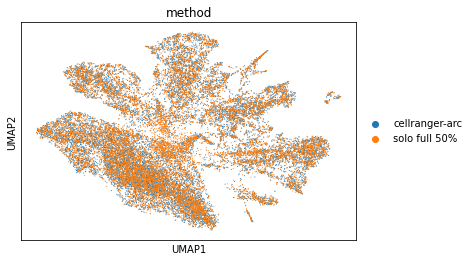

In [46]:
scanpy.pl.umap(combined_genefull, color=['method'])